## Pénalisation hard linéaire

In [21]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

In [22]:
def generate_data(d, n_samples, sigma1, sigma2, correlation):
    x_data_1 = torch.randn(n_samples, d)
    theta1 = torch.randn(d)
    x_data_2 = torch.randn(n_samples, d)
    theta2 = torch.randn(d)

    x_data_2 = correlation*x_data_1 + (1-correlation)*x_data_2
    
    noise_1 = torch.randn(n_samples)*sigma1
    noise_2 = torch.randn(n_samples)*sigma2

    y_data = torch.zeros(n_samples, 3)
    y_data[:,0] = x_data_1@theta1 + noise_1
    y_data[:,1] = x_data_2@theta2 - noise_1 + noise_2
    y_data[:,2] = y_data[:,0]+y_data[:,1]
    return x_data_1, x_data_2, y_data

In [23]:
d = 30
n_samples = 10**2
sigma1 = 1
sigma2 = 0.1

torch.random.manual_seed(11)

x_data_1, x_data_2, y_data = generate_data(d, n_samples, sigma1, sigma2, 0)

In [24]:
x_train_1 = x_data_1[1:n_samples*4//5]
x_train_2 = x_data_2[1:n_samples*4//5]
y_train = y_data[1:n_samples*4//5]

x_test_1 = x_data_1[n_samples*4//5:]
x_test_2 = x_data_2[n_samples*4//5:]
y_test = y_data[n_samples*4//5:]

In [25]:
def estimation(x_train_1, x_train_2, y_train, lambda_ridge):
    x1x1 = x_train_1.T@x_train_1
    x2x2 = x_train_2.T@x_train_2
    x1x2 = x_train_1.T@x_train_2
    x2x1 = x_train_2.T@x_train_1
    cov11 = x_train_1.T@y_train[:,0]
    cov22 = x_train_2.T@y_train[:,1]
    cov12 = x_train_1.T@y_train[:,1]
    cov21 = x_train_2.T@y_train[:,0]
    
    quotient = lambda_ridge**2/(1+lambda_ridge)
    inv1 = -quotient*x1x2@torch.linalg.solve(x2x2,x2x1)
    y_tilde1 = (1+lambda_ridge)*cov11-lambda_ridge*x1x2@torch.linalg.solve(x2x2,cov22)-quotient*x1x2@torch.linalg.solve(x2x2,cov21)+lambda_ridge*cov12
    hat_theta1 = torch.linalg.solve((1+lambda_ridge)*x1x1+inv1,y_tilde1)

    inv2 = -quotient*x2x1@torch.linalg.solve(x1x1,x1x2)
    y_tilde2 = (1+lambda_ridge)*cov22-lambda_ridge*x2x1@torch.linalg.solve(x1x1,cov11)-quotient*x2x1@torch.linalg.solve(x1x1,cov12)+lambda_ridge*cov21
    hat_theta2 = torch.linalg.solve((1+lambda_ridge)*x2x2+inv2,y_tilde2)
    return hat_theta1, hat_theta2

In [26]:
lambda_ridge = 10**10
hat_theta1, hat_theta2 = estimation(x_train_1, x_train_2, y_train, lambda_ridge)

In [27]:
def performance(hat_theta1, hat_theta2, x_test_1, x_test_2, y_test):
    err_y1 = torch.sqrt(torch.mean(torch.square(x_test_1@hat_theta1-y_test[:,0]))).item()
    err_y2 = torch.sqrt(torch.mean(torch.square(x_test_2@hat_theta2-y_test[:,1]))).item()
    err_sum = torch.sqrt(torch.mean(torch.square(x_test_1@hat_theta1-y_test[:,0]+x_test_2@hat_theta2-y_test[:,1]))).item()
    return err_y1, err_y2, err_sum

In [28]:
performance(hat_theta1, hat_theta2, x_test_1, x_test_2, y_test)

(0.9151715065117912, 1.0057909924135502, 0.16826239833970127)

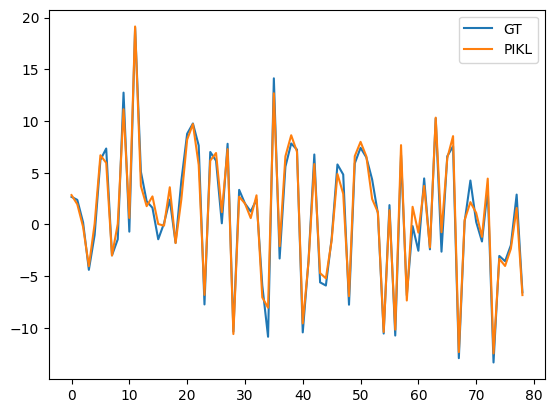

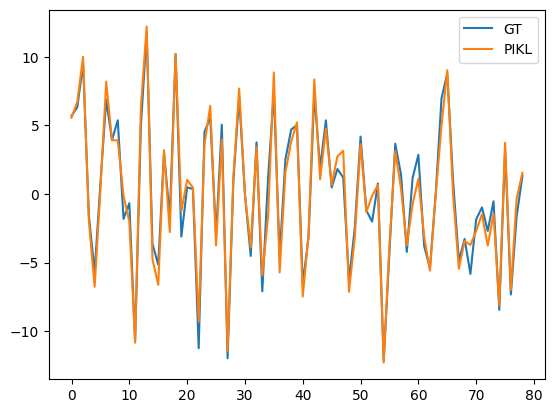

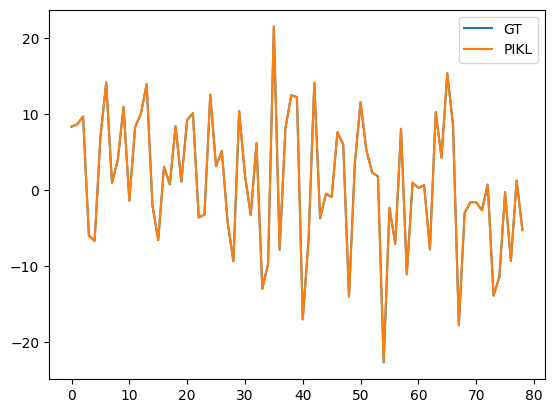

In [29]:
plt.plot(y_train[:,0], label='GT')
plt.plot(x_train_1@hat_theta1, label="PIKL")
plt.legend()
plt.figure()
plt.plot(y_train[:,1], label='GT')
plt.plot(x_train_2@hat_theta2, label="PIKL")
plt.legend()
plt.figure()
plt.plot(y_train[:,0]+y_train[:,1], label='GT')
plt.plot(x_train_1@hat_theta1+x_train_2@hat_theta2, label="PIKL")
plt.legend()

# Performance over several draws

In [30]:
def monte_carlo(n_draws, d, n_samples, sigma1, sigma2, correlation, lambda_ridge):
    err_linear_bottom = []
    err_reconcile = []
    err_hierarchical = []

    S_mat = torch.tensor([[1.,0],[0,1],[1,1]])
    transform = S_mat@torch.linalg.solve(S_mat.T@S_mat, S_mat.T)
    for draw in range(n_draws):
        x_data_1, x_data_2, y_data = generate_data(d, n_samples, sigma1, sigma2, correlation)
        x_train_1 = x_data_1[:n_samples*4//5]
        x_train_2 = x_data_2[:n_samples*4//5]
        y_train = y_data[:n_samples*4//5]

        x_test_1 = x_data_1[n_samples*4//5:]
        x_test_2 = x_data_2[n_samples*4//5:]
        y_test = y_data[n_samples*4//5:]
        hat_theta1, hat_theta2 = estimation(x_train_1, x_train_2, y_train, 0)
        err_linear_bottom.append(performance(hat_theta1, hat_theta2, x_test_1, x_test_2, y_test))
        
        x_train = torch.concatenate((x_train_1, x_train_2), dim=1)
        x_test = torch.concatenate((x_test_1, x_test_2), dim=1)
        theta_3 = torch.linalg.solve(x_train.T@x_train, x_train.T@y_train[:,2])
        y_hat = torch.concatenate(((x_test_1@hat_theta1).view(-1,1),(x_test_2@hat_theta2).view(-1,1), (x_test@theta_3).view(-1,1) ), dim=1).T
        y_reconcile = (transform@y_hat).T
        err_1 = torch.sqrt(torch.mean(torch.square(y_reconcile[:,0]-y_test[:,0])))
        err_2 = torch.sqrt(torch.mean(torch.square(y_reconcile[:,1]-y_test[:,1])))
        err_sum = torch.sqrt(torch.mean(torch.square(y_reconcile[:,2]-y_test[:,2])))
        err_reconcile.append([err_1, err_2, err_sum])

        hat_theta1, hat_theta2 = estimation(x_train_1, x_train_2, y_train, lambda_ridge)
        err_hierarchical.append(performance(hat_theta1, hat_theta2, x_test_1, x_test_2, y_test))
        
    return err_linear_bottom, err_reconcile, err_hierarchical


In [31]:
torch.random.manual_seed(1)
n_draws = 10
d = 60
n_samples = 100
sigma1 = 1
sigma2= 0.2
correlation = 0
lambda_ridge = 10**10

err_bottom_up,err_reconcile, err_hierarchical = monte_carlo(n_draws, d, n_samples, sigma1, sigma2, correlation, lambda_ridge)

In [32]:
err_bottom_up = np.array(err_bottom_up)
err_reconcile = np.array(err_reconcile)
err_hierarchical = np.array(err_hierarchical)

print(np.mean(err_bottom_up, axis=0))
print(np.std(err_bottom_up, axis=0)/np.sqrt(n_draws))
print(np.mean(err_reconcile, axis=0))
print(np.std(err_reconcile, axis=0)/np.sqrt(n_draws))
print(np.mean(err_hierarchical, axis=0))
print(np.std(err_hierarchical, axis=0)/np.sqrt(n_draws))



[1.90263019 1.82527902 2.42182614]
[0.12049535 0.11130683 0.18097222]
[244.93205483 245.2437576  490.11579344]
[196.14551736 196.09090527 392.24288736]
[1.67326875 1.61850716 1.99846822]
[0.10433237 0.07719928 0.13132458]


In [35]:
torch.random.manual_seed(1)

err_bottom_up_list, err_reconcile_list, err_hier_list = [], [], []
sigma2_list = [i/30 for i in range(1,30)]
for sigma2 in sigma2_list:
    n_draws = 10**3
    d = 35
    n_samples = 100
    sigma1 = 1
    correlation = 0
    lambda_ridge = 1/sigma2**2

    err_bottom_up,err_reconcile, err_hierarchical = monte_carlo(n_draws, d, n_samples, sigma1, sigma2, correlation, lambda_ridge)
    err_bottom_up_list.append(np.mean(err_bottom_up, axis=0))
    err_reconcile_list.append(np.mean(err_reconcile, axis=0))
    err_hier_list.append(np.mean(err_hierarchical, axis=0))

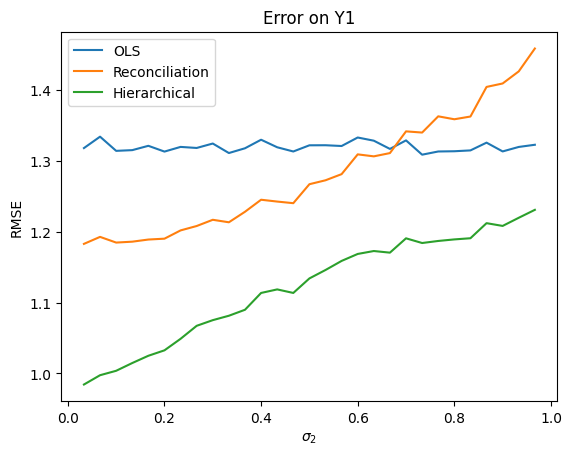

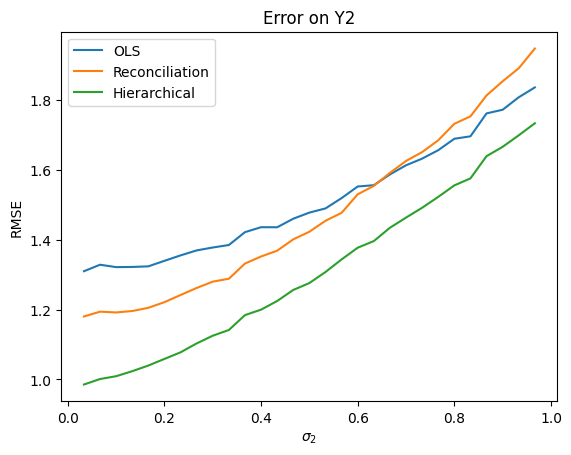

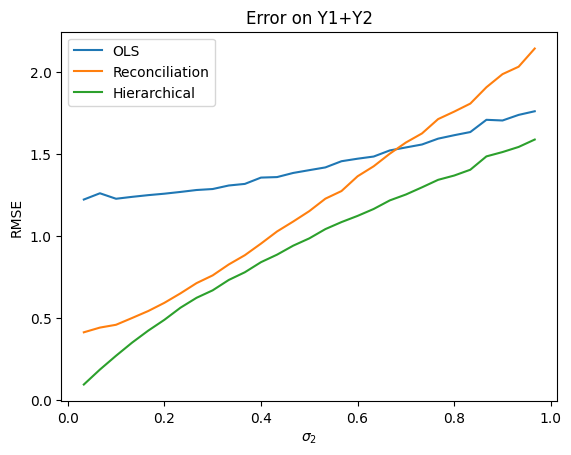

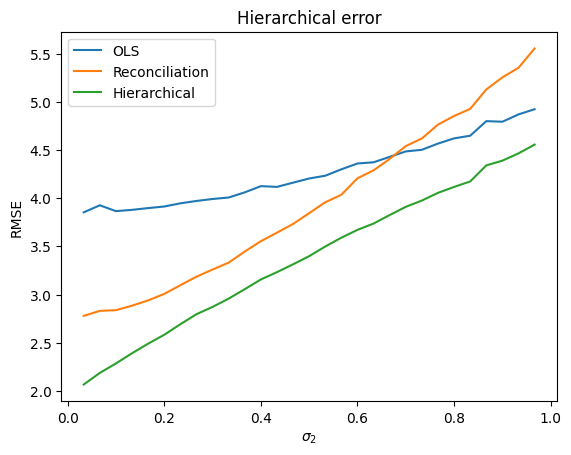

In [36]:
err_bottom_up_list = np.array(err_bottom_up_list)
err_reconcile_list = np.array(err_reconcile_list)
err_hier_list = np.array(err_hier_list)
targets = ["Y1", "Y2", "Y1+Y2"]

for i in range(3):
    plt.figure()
    plt.plot(sigma2_list, err_bottom_up_list[:,i], label ="OLS")
    plt.plot(sigma2_list, err_reconcile_list[:,i], label = "Reconciliation")
    plt.plot(sigma2_list, err_hier_list[:,i], label = "Hierarchical")
    plt.title("Error on "+targets[i])
    plt.xlabel("$\sigma_2$")
    plt.ylabel("RMSE")
    plt.legend()


plt.figure()
plt.plot(sigma2_list, err_bottom_up_list[:,0]+err_bottom_up_list[:,1]+err_bottom_up_list[:,2], label ="OLS")
plt.plot(sigma2_list, err_reconcile_list[:,0]+err_reconcile_list[:,1]+err_reconcile_list[:,2], label = "Reconciliation")
plt.plot(sigma2_list, err_hier_list[:,0]+err_hier_list[:,1]+err_hier_list[:,2], label = "Hierarchical")
plt.title("Hierarchical error")
plt.xlabel("$\sigma_2$")
plt.ylabel("RMSE")
plt.legend()